In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano as thno
import theano.tensor as T
import warnings

from collections import OrderedDict
from scipy.optimize import fmin_powell
from scipy import integrate
from time import time

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [3]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('income ~ educ + hours + age ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

In [5]:
# datasets

raw_data = pd.read_csv("./dataset_spine.csv")
raw_data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


In [29]:
# datasets

raw_data = pd.read_csv("./dataset_spine.csv",
                       header=None,
                       skiprows=[0],
                       names=['pelvic_incidence', 
                              'pelvic_tilt', 
                              'lumbar_lordosis_angle',
                              'sacral_slope', 
                              'pelvic_radius',
                              'degree_spondylolisthesis', 
                              'pelvic_slope',
                              'direct_tilt', 
                              'thoracic_slope', 
                              'cervical_tilt',
                              'sacrum_angle', 
                              'scoliosis_slope',
                              'hours', 
                              'back_status',
                              'notes'])
raw_data[raw_data.columns[:5]]

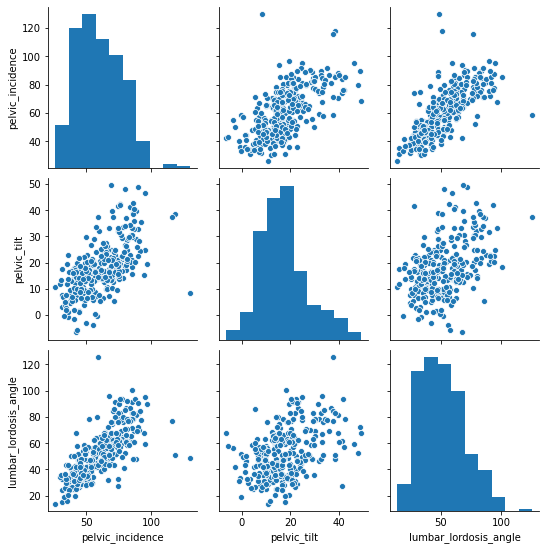

In [33]:
g = seaborn.pairplot(raw_data[raw_data.columns[:3]])

In [35]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('back_status ~ pelvic_incidence + pelvic_tilt',
                            raw_data[['back_status', 'pelvic_incidence', 'pelvic_tilt']],
                            family=pm.glm.families.Binomial())
    trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pelvic_tilt, pelvic_incidence, Intercept]
Sampling 4 chains, 3,813 divergences: 100%|█| 8000/8000 [00:38<00:00, 208.49dra
There were 988 divergences after tuning. Increase `target_accept` or reparameterize.
There were 992 divergences after tuning. Increase `target_accept` or reparameterize.
There were 835 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8889492012381115, but should be close to 0.8. Try to increase the number of tuning steps.
There were 994 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
plot_traces(trace)

F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
